# 使用神经网络去除雨

这个notebook是用来训练神经网络模型，需要电脑配置较高，否则运行会比较慢，我电脑的配置是如下图所示，迭代运行150 epoch耗时半个小时左右，你可以参考一下，在运行之前记得修改下面保存模型的名字，保存为自己想要的名字：

![](../img/computerSys.png)


本程序运行需要以下模块:
* tensorflow-gpu 2.4.x
* pydot

In [1]:
# 导入模块
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Concatenate
from keras.layers import Conv2D, Conv2DTranspose, Activation, MaxPooling2D, UpSampling2D
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.models import Model
from keras.models import load_model
import tensorflow as tf
from keras import backend as K
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
from keras import losses
import gc

physical_device = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_device[0], True)

In [2]:
# 读取训练数据
images = []
image_shape = (256, 256)
epochs = 100
batch_size = 10
img_path = '../datasets/derain/training/'
for i in os.listdir(img_path):
    images.append(cv2.imread(img_path + i))
len(images)

700

## 数据预处理

可以查看训练图片，其左边一半为原图，右边一半为添加雨的图片，首先读取训练数据集文件夹下所有图片，这里的训练数据集在 `dataset/derain/training/` ，然后通过numpy切片分开输入即带雨的图像和输出即不带雨的图片

有一点必须要注意，输入的图片和输出的图片必须分别符合神经网络输入层和输出层的参数，这里我设置的图片大小为 512 x 512，神经网络的输入层和输出层也是必须也 512 x 512

In [3]:
# 训练集数据resize
co = 0
rain_im = []
derain_im = []
for i in images:
    co += 1
    col = i.shape[1]
    im = i[:,:col//2,:]
    im2 = i[:,col//2:,:]
    derain_im.append(im)
    rain_im.append(im2)
del images
gc.collect()

44

In [4]:
derain_final = []
for i in derain_im:
    x = cv2.resize(i, image_shape)
    x = x/255
    derain_final.append(x)
del derain_im
gc.collect()

20

In [5]:
rain_final = []
for i in rain_im:
    x = cv2.resize(i, image_shape)
    x = x/255
    rain_final.append(x)
del rain_im
gc.collect()

20

In [6]:
rain_final_train = np.asarray(rain_final[:600])
rain_final_test = np.asarray(rain_final[600:700])
print(rain_final_train.shape, rain_final_test.shape)
del rain_final
gc.collect()

(600, 256, 256, 3) (100, 256, 256, 3)


20

In [7]:
derain_final_train = np.asarray(derain_final[:600])
derain_final_test = np.asarray(derain_final[600:700])
print(derain_final_test.shape, derain_final_train.shape)
del derain_final
gc.collect()

(100, 256, 256, 3) (600, 256, 256, 3)


20

## 定义神经网络模型

这里的神经网络模型定义如下，得到的模型图为：

![](../img/model.png)

In [8]:
input_img = Input(shape=(image_shape[1], image_shape[0], 3))

x = Conv2D(16, (4, 4), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid',padding = 'same')(x)

#decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss=losses.mean_squared_error, metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      784       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 32)        18464 

## 模型训练

这里开始模型的训练，设置的迭代次数 $epochs=150$，可以相应的调小一点训练， $batch_size=30$ 是每次批量训练的样本数，如果电脑显卡显存够高，可以提高一点

In [9]:
history = Model.fit(autoencoder, rain_final_train, derain_final_train, validation_data=(rain_final_test, derain_final_test), epochs=epochs, shuffle=True, batch_size=batch_size)

Epoch 1/100
60/60 [==============================] - 6s 53ms/step - loss: 0.0515 - accuracy: 0.4809 - val_loss: 0.0196 - val_accuracy: 0.6159
Epoch 2/100
60/60 [==============================] - 3s 48ms/step - loss: 0.0188 - accuracy: 0.6485 - val_loss: 0.0141 - val_accuracy: 0.6780
Epoch 3/100
60/60 [==============================] - 3s 48ms/step - loss: 0.0160 - accuracy: 0.6714 - val_loss: 0.0123 - val_accuracy: 0.6821
Epoch 4/100
60/60 [==============================] - 3s 47ms/step - loss: 0.0130 - accuracy: 0.6960 - val_loss: 0.0119 - val_accuracy: 0.7256
Epoch 5/100
60/60 [==============================] - 3s 48ms/step - loss: 0.0118 - accuracy: 0.7473 - val_loss: 0.0113 - val_accuracy: 0.6936
Epoch 6/100
60/60 [==============================] - 3s 48ms/step - loss: 0.0133 - accuracy: 0.7358 - val_loss: 0.0124 - val_accuracy: 0.7469
Epoch 7/100
60/60 [==============================] - 3s 47ms/step - loss: 0.0119 - accuracy: 0.7728 - val_loss: 0.0137 - val_accuracy: 0.7621
Epoch 

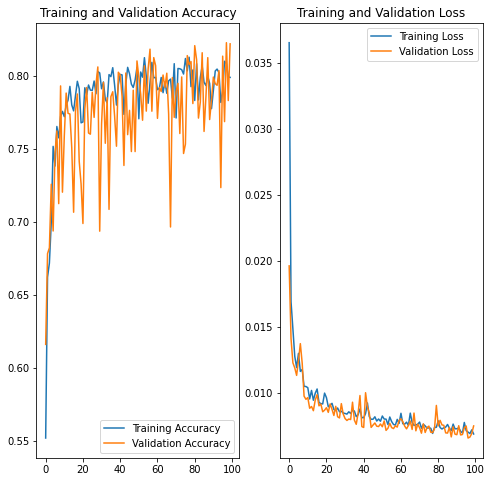

In [10]:
# 绘制准确率和损失误差
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
# 保存模型
autoencoder.save("../models/model256.h5")

In [12]:
auto = load_model("../models/model256.h5")

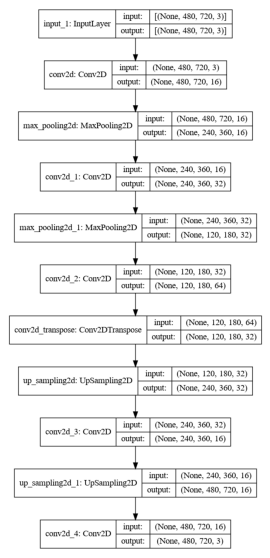

In [13]:
plot_model(auto, to_file='./model256.png', show_shapes=True, show_layer_names=True, rankdir='TB')
img = plt.imread('model.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()